In [118]:
# imports 
import json
import graphviz


In [119]:
#functions
def write_dict_to_json(d, filename):
    new_dict = {}
    for key, value in d.items():
        if isinstance(value, dict):
            new_value = {}
            for sub_key, sub_value in value.items():
                if sub_key == "isTerminatingState":
                    new_value[sub_key] = True
                else:
                    new_value[sub_key] = list(sub_value)
            new_dict[key] = new_value
        else:
            new_dict[key] = value
    with open(filename, "w") as f:
        json.dump(new_dict, f)

def match_2_chars(regex, char1, char2):
    matches = []
    stack = []

    # iterate through each character in the regex string
    for i, c in enumerate(regex):
        # check if the current character is equal to char1 and not escaped
        if c == char1 and (i == 0 or regex[i-1] != "\\"):
            stack.append(i) # add the index to the stack
        # check if the current character is equal to char2 and not escaped
        elif c == char2 and (i == 0 or regex[i-1] != "\\"):
            if not stack: # if stack is empty
                raise Exception(f"Unmatched {char2}")
            matches.append((stack.pop(), i)) # add a tuple of matched indices to matches list
    if stack: # if there are any indices left on the stack
        raise Exception(f"Unmatched {char1}")
    return matches

def add_key_val(NFA, key1, key2, val): # add a key-value pair to the NFA dictionary (if it doesn't already exist)
    if not NFA.get(key1):
        NFA[key1] = {}
    if not NFA[key1].get(key2):
        NFA[key1][key2] = {val}
    NFA[key1][key2].add(val)

    return NFA

def get_containing_brackets(brackets):
    """Returns a list of tuples of the form ((start, end), [containing brackets])"""
    result = []
    for i, (s1, e1) in enumerate(brackets):
        containing_brackets = []
        for s2, e2 in brackets[i+1:]:
            if s2 > s1 and e1 > e2:
                containing_brackets.append((s2, e2))
        result.append(((s1, e1), containing_brackets))
    return result


def remove_unnecessary_brackets(regex, outer_bracket, inner_brackets):
    """Removes unnecessary brackets from the regex string and returns the new regex string"""

    s1, e1 = outer_bracket
    num_removed = 0
    
    for i in range(len(inner_brackets)):
        s2, e2 = inner_brackets[i]
        if s2 - s1 == 1 + num_removed and e1 - e2 == 1 + num_removed:
            num_removed += 1
            inner_brackets.pop(i)
            regex = regex[:e2] + regex[e2 + 1:s2] + regex[s2 + 1:]
            return remove_unnecessary_brackets(regex, outer_bracket, inner_brackets)
            
    return (outer_bracket, inner_brackets)



def get_next_brackets(regex, brackets):
    """This function takes a regular expression and a generator of containing brackets as input, 
and returns the next outer bracket and list of inner brackets. It first attempts to get the next tuple of
containing brackets from the generator using the next() function. If a tuple is returned, 
the function calls remove_unnecessary_brackets() on the regular expression and the tuple, and returns the resulting tuple.
If there are no more tuples in the generator, the function returns None, None."""

    if not brackets:
        return None, None
    try:
        (outer_bracket, inner_brackets) = next(brackets)
        return remove_unnecessary_brackets(regex, outer_bracket, inner_brackets)
    except StopIteration:
        return None, None


def get_brackets(regex):
    """This function takes a regular expression as input, and returns a generator of containing brackets."""
    brackets = match_2_chars(regex, "[", "]") +match_2_chars(regex, "(", ")")
    brackets = sorted(brackets, key=lambda x: x[0])
    return (x for x in get_containing_brackets(brackets))


def get_split_indices_for_or_operation(regex):

    brackets = list(get_brackets(regex))

    or_location = [i for i, c in enumerate(regex) if c == "|"]

    final_or_locations = []
    for or_index in or_location:
        temp = True
        for outer, _ in brackets:
            if outer[0] < or_index < outer[1]:
                temp = False
                break
        if temp:
            final_or_locations.append(or_index)

    return final_or_locations

def add_key_val_dfa(DFA, key1, key2, val):
    if not DFA.get(key1):
        DFA[key1] = {}
    if not DFA[key1].get(key2):
        DFA[key1][key2] = val
    return DFA

def rename_dfa(dfa, accepting_states, start_state):

    increment = 0
    visited = set()
    name_dict = {}
    new_dfa = {}

    for state1, transitions in dfa.items():
        if state1 not in visited:
            visited.add(state1)
            name_dict[state1] = increment
            increment += 1
        for input_char, state2 in transitions.items():
            if state2 not in visited:
                visited.add(state2)
                name_dict[state2] = increment
                increment += 1

    accepting_states = {name_dict[state] for state in accepting_states}
    start_state = name_dict[start_state]

    for state1, transitions in dfa.items():
        new_dfa[name_dict[state1]] = {}
        for input_char, state2 in transitions.items():
            new_dfa[name_dict[state1]][input_char] = name_dict[state2]

    new_dfa["startingState"] = start_state

    return new_dfa, accepting_states



In [120]:
# validate regex
import re

class RegexValidator:
    def __init__(self, regex):
        self.regex = regex

    def validate(self):
        try:
            re.compile(self.regex)
            return True
        except re.error:
            return False


In [121]:
# nfa construction

def construct_nfa(regex):
    # initialize NFA
    NFA = {0: {}, "startingState": 0}
    last_state, NFA = get_regex(regex, NFA, 0)
    add_key_val(NFA, last_state, 'isTerminatingState', True)
    return NFA

def get_regex(regex, NFA, current_state, in_brackets=False, bracket_type=None):
    # 1. if regex is empty, return current state
    if not regex:
        return current_state, NFA
    #2. if regex is a single character, add it to the NFA
    i = 0 # index of regex
    start_state = current_state # start state of the current regex

    split_indices = get_split_indices_for_or_operation(regex) # indices of | in regex 
 
    if split_indices: # one OR or more in regex
        split_indices = [-1] + split_indices # adding -1 to the beginning of the list to make the first split easier 
        split_indices.append(len(regex) + 1) # adding len(regex) + 1 to the end of the list to make the last split easier

        new_split_indices = [ # getting the indices of the regex to be split
            (split_indices[i], split_indices[i + 1])  
            for i in range(len(split_indices) - 1)
        ] 

        regex_arr = [regex[x[0] + 1: x[1]] for x in new_split_indices] # splitting the regex into substrings

        current_state, NFA = or_operator(regex_arr, NFA, current_state, start_state) # calling the or operator function on the substrings
    else: # no OR in regex
        # here we check if the regex is in brackets
        brackets = get_brackets(regex) # getting the brackets in the regex
        (current_outer_bracket, current_inner_brackets) = get_next_brackets( # getting the next brackets
            regex, brackets
        )
        while i < len(regex):
            # checking for alnum
            if bracket_type == "[":
                
                while regex.find("-") != -1:
                    index = regex.find("-")
                    if index == 0:
                        set_alnum_state(regex[0], NFA, current_state, current_state + 1)
                        regex = regex[index + 1:]
                        continue
                    elif index == len(regex) - 1:
                        set_alnum_state(regex[-1], NFA, current_state, current_state + 1)
                        regex = regex[:index]
                        continue
                    else:
                        char_before, char_after = regex[index - 1], regex[index + 1]
                        if ord(char_before) > ord(char_after):
                            raise Exception(
                                f"Invalid {char_before}-{char_after} range"
                            )
                        set_alnum_state(regex[index - 1: index + 2], NFA, current_state, current_state + 1)
                        regex = regex[:index - 1] + regex[index + 2:]
                for char in regex[i:]:
                    set_alnum_state(char, NFA, current_state, current_state + 1)
                current_state += 1
                break
            # checking for brackets
            elif current_outer_bracket and i == current_outer_bracket[0]:

                if (current_outer_bracket[1] + 1) < len(regex) and regex[
                    current_outer_bracket[1] + 1
                ] in regex_operators.keys():
                    current_state, new_NFA = regex_operators[
                        regex[current_outer_bracket[1] + 1]
                    ](
                        regex[i + 1: current_outer_bracket[1]],
                        NFA,
                        current_state,
                        bracket_type=regex[i],
                        regex_fn=get_regex,
                    )
                    i = current_outer_bracket[1] + 2
                else:
                    # we are at the start of the outer bracket
                    current_state, new_NFA = get_regex(
                        regex[i + 1: current_outer_bracket[1]],
                        NFA,
                        current_state,
                        True,
                        bracket_type=regex[i]
                    )
                    i = current_outer_bracket[1] + 1

                (current_outer_bracket, current_inner_brackets) = get_next_brackets(
                    regex, brackets
                )
            elif regex[i] == '\\' and bracket_type != "[":
                if i + 1 >= len(regex):
                    raise Exception("Escaped character found at end of regex/subregex")
                else:
                    char = regex[i+1]
                    if char in "*+?|()[{^$" :
                        print('escaped')
                        set_alnum_state(char, NFA, current_state, current_state + 1)
                    else:
                        raise Exception(f"Invalid escaped character: \{char}")
                    current_state += 1
                    i += 2
            else:

                char = regex[i]
                if char in "*+?|()[{^$" :
                    raise Exception(f"Escape character is needed before {char}")

                if (i + 1) < len(regex) and regex[i + 1] in regex_operators.keys():
                    current_state, _ = regex_operators[regex[i + 1]](
                        char, NFA, current_state, regex_fn=get_regex
                    )
                    i += 1
                else:
                    set_alnum_state(char, NFA, current_state, current_state + 1)
                    if bracket_type == "(" or bracket_type is None:
                        current_state += 1

                i += 1

    return current_state, NFA
def or_operator(
    regex_arr, NFA, current_state, start_state, bracket_type=None, regex_fn=get_regex
):

    end_states = []
    for regex in regex_arr:
        current_state += 1
        add_key_val(NFA, start_state, 'ε' , current_state)
        current_state, NFA = regex_fn(
            regex, NFA, current_state, bracket_type=bracket_type
        )
        end_states.append(current_state)
    current_state += 1
    for end_state in end_states:
        add_key_val(NFA, end_state, 'ε' , current_state)

    return current_state, NFA

def set_alnum_state(char, NFA, current_state, next_state):
    add_key_val(NFA, current_state, char, next_state)

# 

def astres(regex, NFA, current_state, bracket_type=None, regex_fn=get_regex):

    add_key_val(NFA, current_state, 'ε' , current_state + 1)
    current_state += 1
    start_state = current_state
    new_state, new_NFA = regex_fn(regex, NFA, start_state, bracket_type=bracket_type)

    add_key_val(NFA, start_state, 'ε' , new_state + 1)
    add_key_val(NFA, new_state, 'ε' , start_state)
    add_key_val(NFA, new_state, 'ε' , new_state + 1)
    NFA[new_state + 1] = dict()
    NFA = {**NFA, **new_NFA}
    return new_state + 1, NFA


def plus(regex, NFA, current_state, bracket_type=None, regex_fn=get_regex):
    start_state = current_state
    new_state, new_NFA = regex_fn(regex, NFA, current_state, bracket_type=bracket_type)

    add_key_val(NFA, new_state, 'ε' , start_state)
    return new_state, NFA



def optional(regex, NFA, current_state, bracket_type=None, regex_fn=get_regex):
    start_state = current_state
    current_state, NFA = regex_fn(regex, NFA, current_state, bracket_type=bracket_type)
    add_key_val(NFA, start_state, 'ε' , current_state)
    return current_state, NFA



regex_operators = {"*": astres, "?": optional, "+": plus}


In [122]:
# convert NFA to DFA 

def convert_to_dfa(states_dict):

    start_state_nfa = states_dict["startingState"]
    start_state = EPSILON_closure([start_state_nfa], states_dict)

    DFA, accepting_states = generate_dfa(start_state, states_dict)

    return rename_dfa(DFA, accepting_states, frozenset(start_state))


def generate_dfa(start_state, states_dict):

    dfa = {}
    accepting_states = set()
    states_queue = [frozenset(start_state)]
    visited_states = set()
    while states_queue:
        current_states = states_queue.pop()
        visited_states.add(current_states)

        moves = get_all_moves(current_states, states_dict)
        for k, v in moves.items():
            if k == "isTerminatingState":
                accepting_states.add(current_states)
                continue
            moves[k] = EPSILON_closure(v, states_dict)
            add_key_val_dfa(dfa, current_states, k, frozenset(moves[k]))
            if frozenset(moves[k]) not in visited_states and frozenset(moves[k]) not in states_queue:
                states_queue.append(frozenset(moves[k]))

    return dfa, accepting_states

def EPSILON_closure(states, states_dict):
    states_list = list(states)
    visited_states = set()

    while states_list:
        current_state = states_list.pop()
        visited_states.add(current_state)

        for state in states_dict[current_state].get('ε' , []):
            if state not in visited_states:
                states_list.append(state)

    return visited_states


def move(states, char, states_dict):
    # returns all states reachable from each state on char
    next_states = set()
    for state in states:
        next_states = next_states.union(states_dict[state].get(char, set()))

    return next_states


def get_all_moves(states, states_dict):

    moves = {}
    for state in states:
        for char_input in states_dict[state].keys():
            if char_input != 'ε' :
                moves[char_input] = moves.get(char_input, set()).union(
                    states_dict[state][char_input]
                )

    return moves

def change_keys_to_ints(states_dict):
    new_states_dict = {}
    for k, v in states_dict.items():
        if k != "startingState":
            new_states_dict[int(k)] = v
        else:
            new_states_dict[k] = v
    
    for k, v in new_states_dict.items():
        if k == "startingState": continue
        if "isTerminatingState" in v.keys():
            new_states_dict[k]["isTerminatingState"] = { True }
    return new_states_dict




In [123]:
# minimize DFA
def get_inputs_and_non_acc_states(state_dict, accepting_states):
    non_accepting_states = set()
    dfa_inputs = set()
    for state1, v in state_dict.items():
        if state1 == "startingState":
            continue
        if state1 not in accepting_states:
            non_accepting_states.add(state1)
        for input_char, state2 in v.items():
            if state2 not in accepting_states:
                non_accepting_states.add(state2)
            if input_char not in dfa_inputs:
                dfa_inputs.add(input_char)

    return non_accepting_states, dfa_inputs


class ListSet:
    def __init__(self, my_set) -> None:
        self.my_set = my_set
        if self.my_set:
            self.representative = next(iter(self.my_set))
        else:
            self.representative = None

    def contains(self, item):
        return item in self.my_set

    def __len__(self):
        return len(self.my_set)

    def reset_representative(self):
        self.representative = next(iter(self.my_set)) if self.my_set else None

    def get_list(self):
        return list(self.my_set)

    def __iter__(self):
        return iter(self.my_set)


def get_groups(state_dict, TT, dfa_inputs):

    while True:
        no_change = True

        for state_set in TT:
            if len(state_set) == 1:
                continue
            for dfa_input in dfa_inputs:
                outputs = []
                for state1 in state_set.my_set:
                    if (state_dict.get(state1, None) is None):
                        state_dict[state1] = {}
                    outputs.append(state_dict[state1].get(dfa_input, None))

                state_destination = []
                for output in outputs:
                    if output is None:
                        state_destination.append(None)
                        continue
                    for state2 in TT:
                        if state2.contains(output):
                            state_destination.append(state2.representative)
                            break
                if len(set(state_destination)) == 1:
                    continue
                else:
                    set_dict = {x: set() for x in state_destination}
                    for state, destination in zip(state_set, state_destination):
                        set_dict[destination].add(state)
                    TT.remove(state_set)
                    for state, destination in set_dict.items():
                        TT.append(ListSet(destination))
                    no_change = False
                    break

        if no_change:
            break

    return TT


def minimize_dfa(state_dict, accepting_states):
    non_accepting_states, dfa_inputs = get_inputs_and_non_acc_states(
        state_dict, accepting_states
    )

    TT = get_groups(
        state_dict, [ListSet(non_accepting_states), ListSet(accepting_states)], dfa_inputs
    )

    TT = [x for x in TT if len(x) > 1]

    renaming_dict = {}
    for group in TT:
        for state in group:
            renaming_dict[state] = group.representative

    new_dfa = {}
    for state, v in state_dict.items():
        if state == "startingState":
            new_dfa["startingState"] = v
        else:
            new_dfa[renaming_dict.get(state, state)] = {}
            for input_char, state2 in v.items():
                if input_char != "isTerminatingState":
                    new_dfa[renaming_dict.get(state, state)][
                        input_char
                    ] = renaming_dict.get(state2, state2)


    return new_dfa, {renaming_dict.get(state, state) for state in accepting_states}


In [124]:
# drawing functions
# draw the NFA

def draw_nfa(states):
    dot = graphviz.Digraph()
    startingState = states['startingState']
    for state, transitions in states.items(): 
        fill_color = 'white'
        if state == 'startingState': #start state
            continue
        if transitions.get('isTerminatingState', None) is not None:
            dot.node(str(state), shape='doublecircle') # add number in the circle
        else:
            if state == startingState:
                fill_color = 'green'
            dot.node(str(state), shape='circle', style='filled', fillcolor=fill_color)
            for char, next_states in transitions.items():
                for next_state in next_states:
                    dot.edge(str(state), str(next_state), label=char)
        #make the graph horizontal
        dot.graph_attr['rankdir'] = 'LR'
    return dot

# draw the DFA
def draw_states_dfa(states_dict, accepting_states):
    dot = graphviz.Digraph()
    startingState = states_dict['startingState']
    for state, transitions in states_dict.items():
        # if transitions =={}:
        #     continue
        fill_color = 'white'
        if state == 'startingState': #start state
            # skip the start state
            continue
        if state in accepting_states:
            dot.node(str(state), shape='doublecircle') # add number in the circle
            for char, next_states in transitions.items():
                if char != 'isTerminatingState':
                    dot.edge(str(state), str(next_states), label=char)
        else:
            if state == startingState:
                fill_color = 'green'
            dot.node(str(state), shape='circle', style='filled', fillcolor=fill_color)
            for char, next_states in transitions.items():
                if char != 'isTerminatingState':
                    dot.edge(str(state), str(next_states), label=char)

        # make the image horizontal
        dot.graph_attr['rankdir'] = 'LR'
    # draw the transitions
    return dot


In [125]:
# Main
def main(regex):
        # convert Regex to NFAs

    validator = RegexValidator(regex)
    if not validator.validate():
        print("Invalid Regex")
        # exit the program
    else:
        NFA = construct_nfa(regex)
        write_dict_to_json(NFA, "nfa.json") #FIXME: we use this function becuase the format of the NFA is not correct 
        print('NFA', NFA)
        image1 = draw_nfa(NFA)
        display(image1)


        # convert NFA to DFA
        NFA= json.load(open("nfa.json", "r"))
        DFA , accepting_states = convert_to_dfa(change_keys_to_ints(NFA))
        # add the accepting states to the DFA 
        DFA2= DFA.copy()
        for state in accepting_states:
            add_key_val_dfa(DFA2, state, "isTerminatingState", "True")
        with open("dfa.json", "w") as f:
            json.dump(DFA2, f, indent=4)
        print('DFA', DFA2)
        # draw the DFA
        image2 = draw_states_dfa(DFA2, accepting_states)
        display(image2)


        # minimize the DFA
        minimized_DFA, minimized_accepting_states = minimize_dfa(DFA, accepting_states)
        minimized_DFA2= minimized_DFA.copy()
        for state in minimized_accepting_states:
            add_key_val_dfa(minimized_DFA2, state, "isTerminatingState", "True")
        
        with open("minimized_dfa.json", "w") as f:
            json.dump(minimized_DFA2, f, indent=4)
        print('minimized DFA', minimized_DFA2)
        # draw the minimized DFA
        image3 = draw_states_dfa(minimized_DFA2, minimized_accepting_states)
        display(image3)


        image1.render(format="png", filename="nfa",view=False)
        image2.render(format="png", filename="dfa",view=False)
        image3.render(format="png", filename="minimized_dfa",view=False)


NFA {0: {'a': {1}}, 'startingState': 0, 1: {'b': {2}}, 2: {'ε': {3}}, 3: {'ε': {9, 4, 6}}, 4: {'b': {5}}, 6: {'c': {7}}, 5: {'ε': {8}}, 7: {'ε': {8}}, 8: {'ε': {9, 3}}, 9: {'d': {10}}, 10: {'ε': {9}, 'isTerminatingState': {True}}}


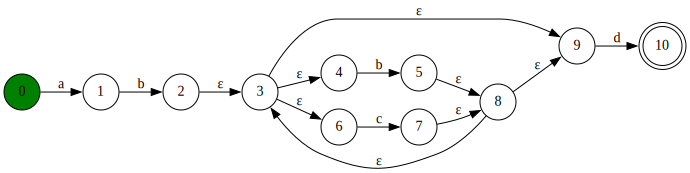

DFA {0: {'a': 1}, 1: {'b': 2}, 2: {'b': 3, 'c': 4, 'd': 5}, 5: {'d': 5, 'isTerminatingState': 'True'}, 4: {'b': 3, 'c': 4, 'd': 5}, 3: {'b': 3, 'c': 4, 'd': 5}, 'startingState': 0}


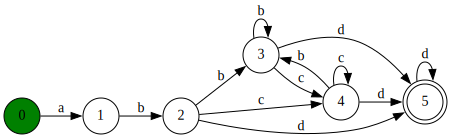

minimized DFA {0: {'a': 1}, 1: {'b': 2}, 2: {'b': 2, 'c': 2, 'd': 5}, 5: {'d': 5, 'isTerminatingState': 'True'}, 'startingState': 0, 'True': {}}


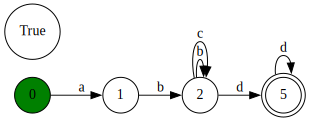

In [126]:
main('ab(b|c)*d+')